In [1]:
import pandas as pd

In [2]:
df_1000=pd.read_csv("amazon_reviews_multi_1000_fr_en_stratified.csv")

In [3]:
print("Taille:", df_1000.shape)
print("\nLangues:")
print(df_1000["language"].value_counts())

print("\nStratification étoiles (global):")
print(df_1000["stars"].value_counts().sort_index())

print("\nStratification étoiles (par langue):")
print(pd.crosstab(df_1000["language"], df_1000["stars"]))


Taille: (1000, 4)

Langues:
language
fr    500
en    500
Name: count, dtype: int64

Stratification étoiles (global):
stars
1    200
2    200
3    200
4    200
5    200
Name: count, dtype: int64

Stratification étoiles (par langue):
stars       1    2    3    4    5
language                         
en        100  100  100  100  100
fr        100  100  100  100  100


In [4]:
def show_examples(df, lang, n=5, seed=42, max_len=300):
    ex = (df[df["language"] == lang]
          .sample(n=n, random_state=seed)
          .loc[:, ["stars", "review_body"]]
          .copy())
    ex["review_body"] = ex["review_body"].astype(str).str.replace(r"\s+", " ", regex=True).str.slice(0, max_len)
    print(f"\n===== EXEMPLES {lang.upper()} (n={n}) =====")
    for i, row in ex.reset_index(drop=True).iterrows():
        print(f"\n--- Exemple {i+1} | stars={row['stars']} ---\n{row['review_body']}")
        
show_examples(df_1000, "fr", n=5, seed=42)
show_examples(df_1000, "en", n=5, seed=42)



===== EXEMPLES FR (n=5) =====

--- Exemple 1 | stars=2 ---
La résine a un très bon effet Mais je suis déçue car il y a des résidus blanc dans le bison A qu'il a fallu "pêcher" avant que la résine ne se fige Pour le prix c'est un peu moyen

--- Exemple 2 | stars=2 ---
Utilisation pour mon portable

--- Exemple 3 | stars=4 ---
Je le rachète à chaque fois pour me laver les dreads. Mousse bien, ne laisse pas de résidus. Les cheveux sont bien nettoyés mais il faut BIEN les hydrater par la suite.

--- Exemple 4 | stars=1 ---
je ne pense pas avoir été suffisamment vigilant quant au délai de livraison annoncé !!! en plus le prix !!! Pour dire que rien ne justifiait le fait que je passe commande chez vous !!! Je ne réitérerai pas, c'est certain !

--- Exemple 5 | stars=4 ---
J'ai déjà commandé et ces têtes durent au moins aussi longtemps que les têtes d'origine

===== EXEMPLES EN (n=5) =====

--- Exemple 1 | stars=1 ---
Bought two based on the number of positive reviews, first one broke within

In [5]:
df_1000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_body       1000 non-null   object
 1   stars             1000 non-null   int64 
 2   product_category  1000 non-null   object
 3   language          1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [6]:
df_1000 = df_1000.rename(columns={"review_body":"text"})

## 1) Exploration rapide (EDA)
### 1.1 Distributions (langue, étoiles, catégories)

In [7]:
display(df_1000["language"].value_counts())
display(df_1000["stars"].value_counts().sort_index())
display(df_1000["product_category"].value_counts().head(10))

language
fr    500
en    500
Name: count, dtype: int64

stars
1    200
2    200
3    200
4    200
5    200
Name: count, dtype: int64

product_category
home                116
wireless             93
toy                  56
drugstore            53
home_improvement     50
other                47
apparel              45
electronics          43
pc                   41
beauty               41
Name: count, dtype: int64

### 1.2 Longueur des textes (diagnostic qualité)

In [8]:
df_1000["n_chars"] = df_1000["text"].astype(str).str.len()
df_1000["n_words"] = df_1000["text"].astype(str).str.split().apply(len)

df_1000[["n_chars","n_words"]].describe()

,n_chars,n_words
count,1000.000000,1000.000000
mean,165.946000,30.487000
std,165.445082,31.054407
min,20.000000,2.000000
25%,63.000000,11.000000
50%,121.000000,22.000000
75%,208.000000,38.000000
max,1751.000000,329.000000


In [9]:
# Exemples 
for lang in ["fr","en"]:
    print("\n====", lang, "====")
    display(df_1000[df_1000["language"]==lang][["stars","text"]].sample(3, random_state=0))



==== fr ====


,stars,text
165,5,Belle couleur...au toucher parfait. S adapte b...
528,1,le produit reçu ne correspond pas à ce que j'a...
597,1,"Bonjour, J'ai reçu mon colis avec d'autre prod..."



==== en ====


,stars,text
193,4,"Good product, brown was a little off on color"
489,4,The grater works okay but not great. The file ...
542,4,"This is a gorgeous band, but a little difficul..."


### 2) Création d’une étiquette de sentiment (baseline)

Basé sur les étoiles (simple et classique) :

- 1–2 → negative

- 3 → neutral

- 4–5 → positive

In [10]:
def stars_to_sentiment(stars):
    if stars <= 2:
        return "negative"
    if stars == 3:
        return "neutral"
    return "positive"

df_1000["sentiment"] = df_1000["stars"].apply(stars_to_sentiment)
df_1000["sentiment"].value_counts()

sentiment
positive    400
negative    400
neutral     200
Name: count, dtype: int64

### 3) Préparation des données

(Nettoyage + Tokenisation + Stopwords + Lemmatisation + POS)

#### 3.1 Nettoyage (léger + stable)

> On garde une version “model-friendly” (lower, suppression URLs) et une version “vader-friendly” (garde ponctuation/majuscules).

In [11]:
import re

URL_RE = re.compile(r"http\S+|www\.\S+")
MULTISPACE_RE = re.compile(r"\s+")

def clean_for_models(text):
    text = str(text)
    text = URL_RE.sub(" ", text)
    text = text.replace("\n", " ")
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text.lower()

def clean_for_vader(text):
    text = str(text)
    text = URL_RE.sub(" ", text)
    text = text.replace("\n", " ")
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text  # on garde majuscules / ponctuation

df_1000["text_clean"] = df_1000["text"].apply(clean_for_models)
df_1000["text_vader"] = df_1000["text"].apply(clean_for_vader)


#### 3.2 Tokenisation + Stopwords (FR+EN) + garde négations

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ressources NLTK (à faire une seule fois)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

stop_fr = set(stopwords.words("french"))
stop_en = set(stopwords.words("english"))
stop_all = stop_fr | stop_en

NEGATIONS = {"ne","pas","jamais","rien","plus","aucun","sans","not","no","never","n't"}
stop_keep_neg = stop_all - NEGATIONS

def tokenize_and_filter(text):
    tokens = word_tokenize(text)
    out = []
    for t in tokens:
        t = t.strip()
        if not t:
            continue
        if len(t) <= 2 and t not in NEGATIONS:
            continue
        if t in stop_keep_neg:
            continue
        # enlève tokens pure ponctuation
        if re.fullmatch(r"\W+", t):
            continue
        out.append(t)
    return out

df_1000["tokens"] = df_1000["text_clean"].apply(tokenize_and_filter)
df_1000[["text_clean","tokens"]].head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tsats\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tsats\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tsats\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text_clean,tokens
0,fonctionne parfaitement très efficace exelent ...,"[fonctionne, parfaitement, très, efficace, exe..."
1,"j'ai reçu mon livre abîmé, il y a une grande c...","[j'ai, reçu, livre, abîmé, grande, coupure, pr..."
2,j'utilise ces boîtes pour faire du diamond.pai...,"[j'utilise, boîtes, faire, diamond.painting, j..."
3,poster beau mes pars contre délai trop long vo...,"[poster, beau, pars, contre, délai, trop, long..."
4,very bland tasting and over-priced whole food ...,"[bland, tasting, over-priced, whole, food, brand]"


#### 3.3 Lemmatisation + POS avec spaCy

In [13]:
#import sys
#!{sys.executable} -m spacy download fr_core_news_sm
#!{sys.executable} -m spacy download en_core_web_sm


In [14]:
import spacy

nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

def spacy_lemmas_pos(text, lang):
    nlp = nlp_fr if lang=="fr" else nlp_en
    doc = nlp(text)
    lemmas = []
    pos = []
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        lemmas.append(tok.lemma_.lower())
        pos.append(tok.pos_)
    return lemmas, pos

df_1000[["lemmas","pos"]] = df_1000.apply(lambda r: pd.Series(spacy_lemmas_pos(r["text"], r["language"])), axis=1)
df_1000[["text","lemmas","pos"]].head()


,text,lemmas,pos
0,Fonctionne parfaitement très efficace exelent ...,"[fonctionne, parfaitement, très, efficace, exe...","[NOUN, ADV, ADV, ADJ, ADV, NOUN, NOUN, NOUN]"
1,"J'ai reçu mon livre abîmé, il y a une grande c...","[je, avoir, recevoir, mon, livre, abîmé, il, y...","[PRON, AUX, VERB, DET, NOUN, ADJ, PRON, PRON, ..."
2,J'utilise ces boîtes pour faire du diamond.pai...,"[je, utiliser, ce, boîte, pour, faire, de, dia...","[PRON, VERB, DET, NOUN, ADP, VERB, DET, NOUN, ..."
3,Poster beau mes pars contre délai trop long vo...,"[poster, beau, mon, par, contre, délai, trop, ...","[VERB, NOUN, DET, NOUN, ADP, NOUN, ADV, ADJ, V..."
4,Very bland tasting and over-priced whole food ...,"[very, bland, tasting, and, over, price, whole...","[ADV, ADJ, ADJ, CCONJ, ADV, VERB, ADJ, NOUN, N..."


## 4) Analyse lexicon-based (polarité) + score

- EN : VADER

- FR : “VADER-FR” si dispo, sinon lexique FR (pédagogique)

In [15]:
# Vader Anglais
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [16]:
import sys
!{sys.executable} -m pip install -U vaderSentiment-fr

In [17]:
# Vader Français
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

vader_fr = SentimentIntensityAnalyzer()
vader_fr.polarity_scores("Une phrase pas cool   à analyser")

c:\Python313\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


{'neg': 0.171, 'neu': 0.829, 'pos': 0.0, 'compound': -0.1139}

In [18]:
def label_from_score(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return "positive"
    if score <= neg_th:
        return "negative"
    return "neutral"

In [19]:
def compute_lex(row):
    if row["language"] == "en":
        comp = vader.polarity_scores(row["text_vader"])["compound"]
        return comp, label_from_score(comp)
    else:
        comp = vader_fr.polarity_scores(row["text_vader"])["compound"]
        return comp, label_from_score(comp)

df_1000[["lex_score","lex_pred"]] = df_1000.apply(lambda r: pd.Series(compute_lex(r)), axis=1)


In [20]:
df_1000[["language","stars","sentiment","lex_score","lex_pred","text"]].head(10)

,language,stars,sentiment,lex_score,lex_pred,text
0,fr,5,positive,0.7960,positive,Fonctionne parfaitement très efficace exelent ...
1,fr,2,negative,-0.4215,negative,"J'ai reçu mon livre abîmé, il y a une grande c..."
2,fr,4,positive,0.2716,positive,J'utilise ces boîtes pour faire du diamond.pai...
3,fr,2,negative,0.1779,positive,Poster beau mes pars contre délai trop long vo...
4,en,1,negative,0.0000,neutral,Very bland tasting and over-priced whole food ...
5,fr,2,negative,0.7342,positive,"Pas prévenu de la livraison, heureusement le c..."
6,fr,5,positive,0.2714,positive,J’ai du Fibaro partout dans la maison et rien ...
7,fr,1,negative,-0.2023,negative,Pour baigner les enfants c'est pratique. Le pr...
8,fr,2,negative,0.0000,neutral,Ne valent pas les chiffons fournis lorsque vou...
9,en,2,negative,-0.4215,negative,Too small. Broke within a month.


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print("=== GLOBAL ===")
print(classification_report(df_1000["sentiment"], df_1000["lex_pred"], digits=3))
print(confusion_matrix(df_1000["sentiment"], df_1000["lex_pred"]))

=== GLOBAL ===
              precision    recall  f1-score   support

    negative      0.708     0.455     0.554       400
     neutral      0.160     0.115     0.134       200
    positive      0.573     0.858     0.687       400

    accuracy                          0.548      1000
   macro avg      0.480     0.476     0.458      1000
weighted avg      0.544     0.548     0.523      1000

[[182  85 133]
 [ 54  23 123]
 [ 21  36 343]]


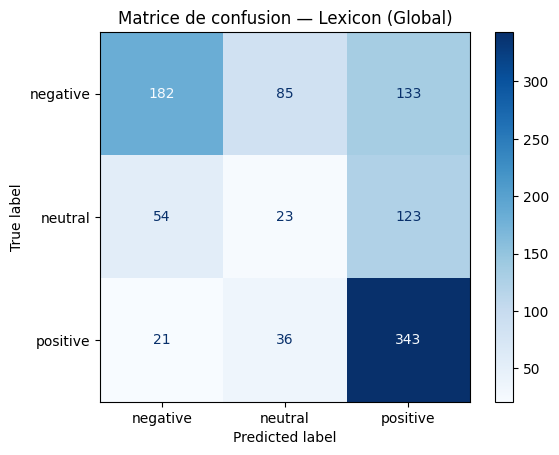

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["negative", "neutral", "positive"]

cm_disp = ConfusionMatrixDisplay.from_predictions(
    y_true=df_1000["sentiment"],
    y_pred=df_1000["lex_pred"],
    labels=labels,
    normalize=None,   # mets "true" pour des % par ligne
    cmap="Blues",
    values_format="d"
)

plt.title("Matrice de confusion — Lexicon (Global)")
plt.show()


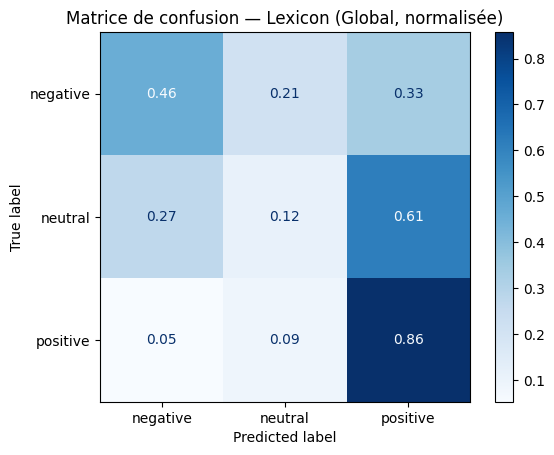

In [23]:
cm_disp = ConfusionMatrixDisplay.from_predictions(
    df_1000["sentiment"], df_1000["lex_pred"],
    labels=labels,
    normalize="true",
    cmap="Blues",
    values_format=".2f"
)
plt.title("Matrice de confusion — Lexicon (Global, normalisée)")
plt.show()

In [24]:
for lang in ["fr","en"]:
    sub = df_1000[df_1000["language"]==lang]
    print(f"\n=== {lang.upper()} ===")
    print(classification_report(sub["sentiment"], sub["lex_pred"], digits=3))
    print(confusion_matrix(sub["sentiment"], sub["lex_pred"]))



=== FR ===
              precision    recall  f1-score   support

    negative      0.713     0.460     0.559       200
     neutral      0.209     0.140     0.168       100
    positive      0.546     0.830     0.659       200

    accuracy                          0.544       500
   macro avg      0.489     0.477     0.462       500
weighted avg      0.545     0.544     0.521       500

[[ 92  34  74]
 [ 22  14  64]
 [ 15  19 166]]

=== EN ===
              precision    recall  f1-score   support

    negative      0.703     0.450     0.549       200
     neutral      0.117     0.090     0.102       100
    positive      0.600     0.885     0.715       200

    accuracy                          0.552       500
   macro avg      0.473     0.475     0.455       500
weighted avg      0.545     0.552     0.526       500

[[ 90  51  59]
 [ 32   9  59]
 [  6  17 177]]


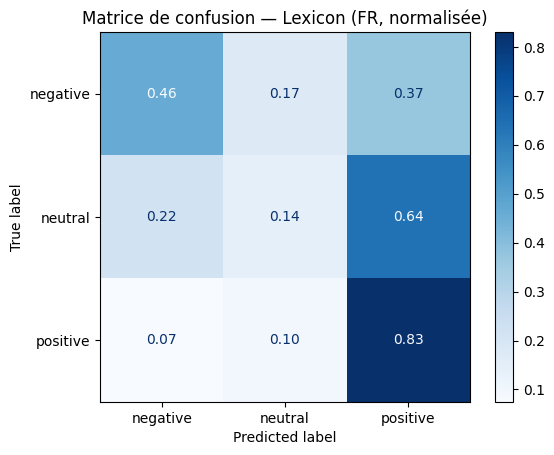

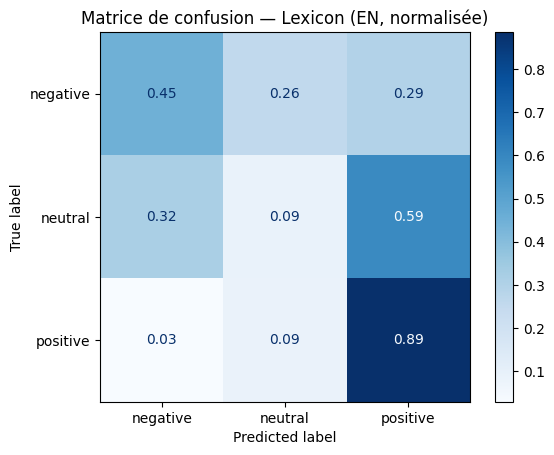

In [25]:
labels = ["negative", "neutral", "positive"]

for lang in ["fr", "en"]:
    sub = df_1000[df_1000["language"] == lang]
    
    ConfusionMatrixDisplay.from_predictions(
        sub["sentiment"], sub["lex_pred"],
        labels=labels,
        normalize="true",
        cmap="Blues",
        values_format=".2f"
    )
    plt.title(f"Matrice de confusion — Lexicon ({lang.upper()}, normalisée)")
    plt.show()


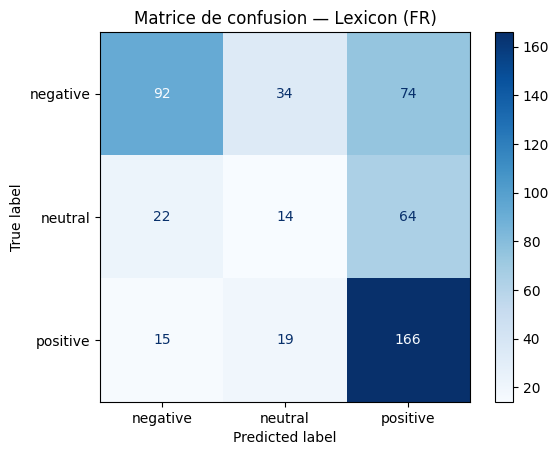

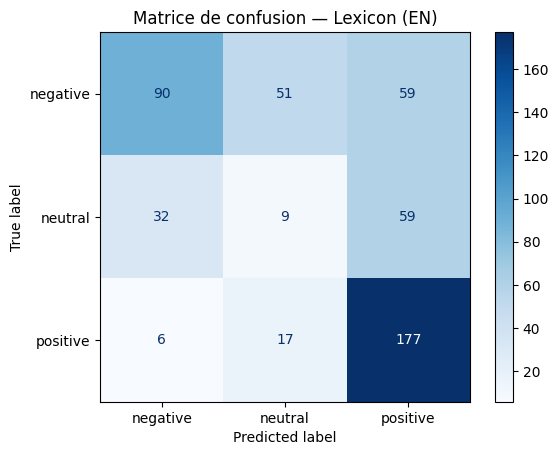

In [26]:
for lang in ["fr", "en"]:
    sub = df_1000[df_1000["language"] == lang]
    
    ConfusionMatrixDisplay.from_predictions(
        sub["sentiment"], sub["lex_pred"],
        labels=labels,
        normalize=None,
        cmap="Blues",
        values_format="d"
    )
    plt.title(f"Matrice de confusion — Lexicon ({lang.upper()})")
    plt.show()


### 5.2 Analyse des erreurs (exemples concrets)

In [27]:
errors = df_1000[df_1000["sentiment"] != df_1000["lex_pred"]]
errors.sample(10, random_state=0)[["language","stars","sentiment","lex_pred","lex_score","text"]]

,language,stars,sentiment,lex_pred,lex_score,text
272,fr,3,neutral,positive,0.0772,"La voix est exceptionnelle, le répertoire faib..."
123,en,3,neutral,positive,0.2382,Good scent but doesn't last long.
642,en,1,negative,positive,0.8767,The idea of the phone wallet is great! We like...
679,en,1,negative,positive,0.8121,From the online advertisement and photos I was...
516,en,1,negative,neutral,0.0000,I never received the package!
306,en,2,negative,neutral,0.0000,Box on the item was ripped
27,fr,5,positive,negative,-0.2263,"Roman court, la suite de la série des jeux. Ra..."
859,fr,3,neutral,negative,-0.5574,mauvaise qualité je trouve
870,fr,3,neutral,positive,0.6705,Bon produit mais j ai l impression qu il sèche...
163,fr,1,negative,neutral,0.0000,"Trop épais , il faudrait changer de pointure d..."


## 6) Approche supervisée : TF/TF-IDF + Naive Bayes

Objectif : entraîner un classifieur de sentiment **supervisé** (étiquette = `sentiment`) à partir du texte (`text_clean`).

Nous allons comparer :

- **Étape 1 :** TF (CountVectorizer) + **MultinomialNB**
- **Étape 2 :** TF-IDF (TfidfVectorizer) + **MultinomialNB**
- **Étape 3 :** interprétation : *features* les plus influentes (Naive Bayes)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# X : listes de tokens issues de l'étape 3.2
X = df_1000["tokens"]
y = df_1000["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Répartition y_train:\n", y_train.value_counts(normalize=True).round(3))
print("Répartition y_test:\n", y_test.value_counts(normalize=True).round(3))


Train: (800,) Test: (200,)
Répartition y_train:
 sentiment
negative    0.4
positive    0.4
neutral     0.2
Name: proportion, dtype: float64
Répartition y_test:
 sentiment
negative    0.4
positive    0.4
neutral     0.2
Name: proportion, dtype: float64


### Étape 1 : TF (CountVectorizer) + MultinomialNB

In [29]:
tf_nb = Pipeline([
    ("vect", CountVectorizer(
        analyzer=lambda x: x,    # x = liste de tokens déjà prête
        tokenizer=None,
        preprocessor=None,
        token_pattern=None,
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", MultinomialNB(alpha=0.5))
])

In [30]:
tf_nb.fit(X_train, y_train)
pred_tf = tf_nb.predict(y_test)

c:\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print("Accuracy:", round(accuracy_score(y_test, pred_tf), 4))
print("F1 macro :", round(f1_score(y_test, pred_tf, average="macro"), 4))
print("\nRapport de classification (global)\n")
print(classification_report(y_test, pred_tf, digits=3))

Accuracy: 0.4
F1 macro : 0.1905

Rapport de classification (global)

              precision    recall  f1-score   support

    negative      0.400     1.000     0.571        80
     neutral      0.000     0.000     0.000        40
    positive      0.000     0.000     0.000        80

    accuracy                          0.400       200
   macro avg      0.133     0.333     0.190       200
weighted avg      0.160     0.400     0.229       200



c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


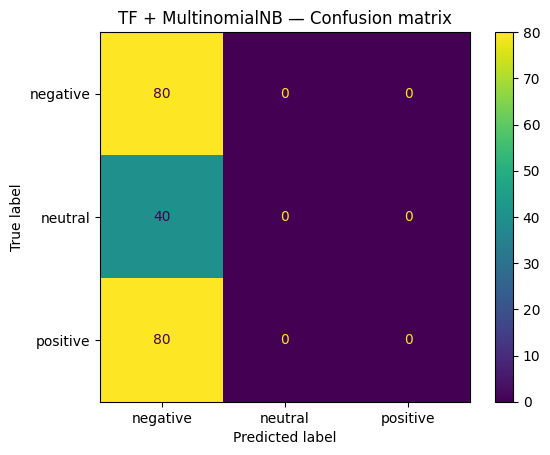

In [32]:
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_tf, labels=["negative","neutral","positive"], cmap=None
)
plt.title("TF + MultinomialNB — Confusion matrix")
plt.show()

In [33]:
# Évaluation par langue (FR/EN) sur le même test
test_idx = X_test.index
for lang in ["fr", "en"]:
    mask = df_1000.loc[test_idx, "language"] == lang
    yt = y_test[mask]
    yp = pd.Series(pred_tf, index=test_idx)[mask]
    print(f"\n--- {lang.upper()} (TF+NB) ---")
    print("n =", mask.sum())
    print("Accuracy:", round(accuracy_score(yt, yp), 4))
    print("F1 macro :", round(f1_score(yt, yp, average='macro'), 4))


--- FR (TF+NB) ---
n = 91
Accuracy: 0.4286
F1 macro : 0.2

--- EN (TF+NB) ---
n = 109
Accuracy: 0.3761
F1 macro : 0.1822


### Étape 2 : TF-IDF + MultinomialNB

In [34]:
tfidf_nb = Pipeline([
    ("vect", TfidfVectorizer(
        analyzer=lambda x: x,
        tokenizer=None,
        preprocessor=None,
        token_pattern=None,
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", MultinomialNB(alpha=0.5))
])

In [35]:
tfidf_nb.fit(X_train, y_train)
pred_tfidf = tfidf_nb.predict(X_test)

c:\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


In [36]:
print("Accuracy:", round(accuracy_score(y_test, pred_tfidf), 4))
print("F1 macro :", round(f1_score(y_test, pred_tfidf, average="macro"), 4))
print("\nRapport de classification (global)\n")
print(classification_report(y_test, pred_tfidf, digits=3))

Accuracy: 0.615
F1 macro : 0.4607

Rapport de classification (global)

              precision    recall  f1-score   support

    negative      0.629     0.762     0.689        80
     neutral      0.000     0.000     0.000        40
    positive      0.626     0.775     0.693        80

    accuracy                          0.615       200
   macro avg      0.418     0.513     0.461       200
weighted avg      0.502     0.615     0.553       200



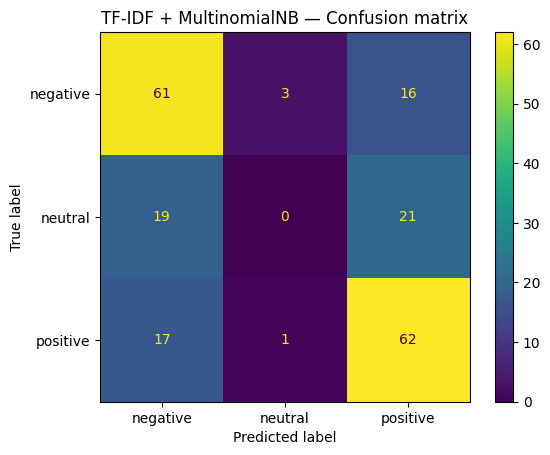

In [37]:
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_tfidf, labels=["negative","neutral","positive"], cmap=None
)
plt.title("TF-IDF + MultinomialNB — Confusion matrix")
plt.show()

In [38]:
# Évaluation par langue (FR/EN)
test_idx = X_test.index
for lang in ["fr", "en"]:
    mask = df_1000.loc[test_idx, "language"] == lang
    yt = y_test[mask]
    yp = pd.Series(pred_tfidf, index=test_idx)[mask]
    print(f"\n--- {lang.upper()} (TF-IDF+NB) ---")
    print("n =", mask.sum())
    print("Accuracy:", round(accuracy_score(yt, yp), 4))
    print("F1 macro :", round(f1_score(yt, yp, average='macro'), 4))


--- FR (TF-IDF+NB) ---
n = 91
Accuracy: 0.6813
F1 macro : 0.495

--- EN (TF-IDF+NB) ---
n = 109
Accuracy: 0.5596
F1 macro : 0.4303


### Étape 3 : *Features* les plus influentes (Naive Bayes)

Pour **MultinomialNB**, on peut exploiter `feature_log_prob_` :

- plus `log P(mot | classe)` est élevé, plus le mot est typique de la classe.
- on affiche ci-dessous les **top mots/bi-grammes** par classe.

In [39]:
import numpy as np
def top_features_multinomial_nb(pipeline, top_n=20):
    vect = pipeline.named_steps["vect"]
    clf  = pipeline.named_steps["clf"]
    feature_names = np.array(vect.get_feature_names_out())
    class_labels = clf.classes_

    for i, cls in enumerate(class_labels):
        top_idx = np.argsort(clf.feature_log_prob_[i])[-top_n:][::-1]
        top_terms = feature_names[top_idx]
        top_scores = clf.feature_log_prob_[i][top_idx]
        print(f"\n=== Classe: {cls} — Top {top_n} features ===")
        for t, s in zip(top_terms, top_scores):
            print(f"{t:<25} {s: .3f}")

print(">>> TOP FEATURES — Modèle TF + NB")
top_features_multinomial_nb(tf_nb, top_n=20)

print("\n\n>>> TOP FEATURES — Modèle TF-IDF + NB")
# Attention : MultinomialNB fonctionne avec TF-IDF, mais les 'top features' sont alors sur les poids TF-IDF.
top_features_multinomial_nb(tfidf_nb, top_n=20)


>>> TOP FEATURES — Modèle TF + NB

=== Classe: negative — Top 20 features ===
pas                       -3.798
not                       -3.992
ne                        -4.348
n't                       -4.735
produit                   -4.781
très                      -4.989
plus                      -5.080
j'ai                      -5.080
product                   -5.146
c'est                     -5.216
one                       -5.291
would                     -5.331
use                       -5.331
car                       -5.373
reçu                      -5.373
qualité                   -5.416
money                     -5.462
get                       -5.510
tout                      -5.510
work                      -5.560

=== Classe: neutral — Top 20 features ===
pas                       -3.992
not                       -4.158
très                      -4.639
ne                        -4.754
peu                       -4.885
qualité                   -5.091
n't                  

## Word embeddings + LSTM 
### Objectifs 

- Comprendre ce qu’est un embedding (représentation dense de mots).

- Passer d’un texte à des séquences d’indices + padding.

- Entraîner un mini-LSTM et lire rapidement accuracy + loss.

## Plan 

### 1) Préparer les données 

* Entrée : `df_1000["text_clean"]` (ou `text_nostop`)
* Cible : `sentiment`
* Split train/test stratifié.

>  Ici, contrairement à NB, **on garde souvent les stopwords** en deep (ils peuvent aider au contexte).

---

### 2) Tokenizer + séquences + padding

* `Tokenizer(num_words=20000, oov_token="<OOV>")`
* `texts_to_sequences`
* `pad_sequences(maxlen=100)` (valeur simple)

Livrable attendu :

* `X_train_pad`, `X_test_pad` (matrices int)
* `y_train`, `y_test` (labels encodés)

---

### 3) Modèle “Embedding + LSTM” minimal 

Architecture simple :

* `Embedding(vocab_size, 64, input_length=maxlen)`
* `LSTM(64)`
* `Dense(n_classes, activation='softmax')` (multiclasse)
  ou `Dense(1, activation='sigmoid')` (binaire)

Compile :

* `adam`
* `sparse_categorical_crossentropy` si labels entiers

---

### 4) Entraîner + évaluer

* `epochs=3` (rapide)
* Afficher :

  * `accuracy` test
  * courbes `loss` et `accuracy` (train/val)

---

### 5) Conclusion

* Comparer qualitativement avec TF-IDF+NB :

  * NB = rapide, très bon baseline
  * LSTM = plus lourd, peut mieux capturer ordre/contexte, mais nécessite plus de données

---


In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

In [41]:
TEXT_COL = "text_clean"      # utilise text_clean (string)
TARGET_COL = "sentiment"     # label (ex: negative/neutral/positive)

df_tmp = df_1000[[TEXT_COL, TARGET_COL]].dropna().copy()
texts = df_tmp[TEXT_COL].astype(str).tolist()
y_raw = df_tmp[TARGET_COL].astype(str).tolist()

In [42]:
from sklearn.preprocessing import LabelEncoder
# Encodage labels -> entiers
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_
n_classes = len(class_names)

print("Classes:", list(class_names), "| n_classes =", n_classes)

Classes: [np.str_('negative'), np.str_('neutral'), np.str_('positive')] | n_classes = 3


In [43]:
# Split stratifié
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
# -----------------------------
# 2) Tokenizer + séquences + padding
# -----------------------------
VOCAB_SIZE = 20000   # taille vocab max (rapide et suffisant)
MAX_LEN = 120        # longueur max de séquence (100-150 OK)
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

# Vocab réel (<= VOCAB_SIZE)
vocab_real = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)
print("Vocab réel:", vocab_real, "| MAX_LEN:", MAX_LEN)

Vocab réel: 4986 | MAX_LEN: 120


In [45]:
# -----------------------------
# 3) Modèle Embedding + LSTM minimal
# -----------------------------
EMB_DIM = 64
LSTM_UNITS = 64

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_real, output_dim=EMB_DIM, input_length=MAX_LEN))
model.add(layers.LSTM(LSTM_UNITS))

if n_classes == 2:
    # binaire
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
else:
    # multiclasse
    model.add(layers.Dense(n_classes, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

c:\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
# -----------------------------
# 4) Entraînement rapide + évaluation
# -----------------------------
EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.3969 - loss: 1.0764 - val_accuracy: 0.3875 - val_loss: 1.0460
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4000 - loss: 1.0658 - val_accuracy: 0.3875 - val_loss: 1.0538
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3844 - loss: 1.0582 - val_accuracy: 0.3875 - val_loss: 1.0465
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3828 - loss: 1.0581 - val_accuracy: 0.3875 - val_loss: 1.0469
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4125 - loss: 1.0578 - val_accuracy: 0.3875 - val_loss: 1.0466
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3875 - loss: 1.0567 - val_accuracy: 0.3875 - val_loss: 1.0465
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4109 - loss: 1.0562 - val_accuracy: 0.4250 - val_loss: 1.0460
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4047 - loss: 1.0574 - val_accuracy: 0.4250 - v

In [47]:
# Prédictions
if n_classes == 2:
    y_proba = model.predict(X_test_pad).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
else:
    y_proba = model.predict(X_test_pad)
    y_pred = np.argmax(y_proba, axis=1)

print("\nAccuracy test:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Accuracy test: 0.405

Classification report:
               precision    recall  f1-score   support

    negative       0.40      1.00      0.57        80
     neutral       0.00      0.00      0.00        40
    positive       1.00      0.01      0.02        80

    accuracy                           0.41       200
   macro avg       0.47      0.34      0.20       200
weighted avg       0.56      0.41      0.24       200

Confusion matrix:
 [[80  0  0]
 [40  0  0]
 [79  0  1]]


c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


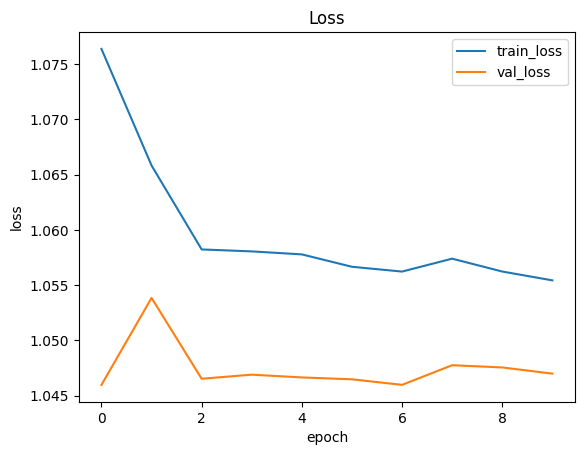

In [48]:
# -----------------------------
# 5) Courbes loss / accuracy
# -----------------------------
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

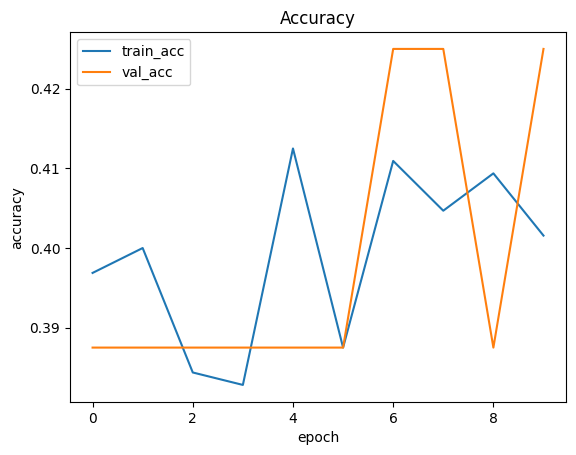

In [49]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()